#### Tech Challenge - Fase 2 - Machine Learning and Time Series

#### O problema 

Desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice

#### O que é o índice Ibovespa 

É o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.


https://pt.wikipedia.org/wiki/Ibovespa

https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/ibovespa.htm

#### Fonte de dados 

Dados históricos do índice IBOVESPA disponíveis publicamente no link https://br.investing.com/indices/bovespa-historical-data e importando para o seguinte repositorio do Github https://github.com/RicardViana/fiap-Machine-Learning-and-Time-Series/blob/main/Dados%20Hist%C3%B3ricos%20Ibovespa.csv

#### Dicionário de dados


| Nome da Coluna | Descrição | Tipo de Dado |
| :--- | :--- | :--- |
| `Data` | A data da observação, no formato "DD/MM/AAAA". | Texto (object) |
| `Ultimo` | O preço de fechamento do Ibovespa no dia. | Numérico (float64) |
| `Abertura` | O preço de abertura do Ibovespa no dia. | Numérico (float64) |
| `Maxima` | O preço máximo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Minima` | O preço mínimo atingido pelo Ibovespa no dia. | Numérico (float64) |
| `Volume` | O volume de negociações do dia. Os valores são representados em texto com sufixos (ex: "B" para bilhões, "M" para milhões). | Texto (object) |
| `Variacao` | A variação percentual do Ibovespa no dia. | Texto (object) |

#### Objetivo

Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja:

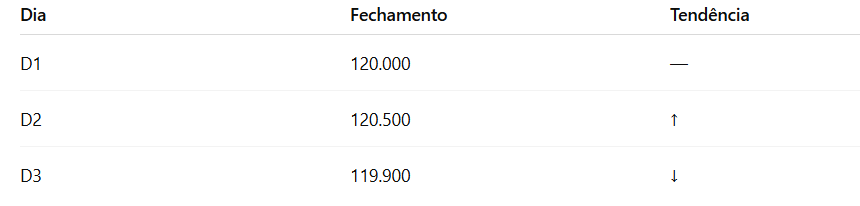

Onde deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste, esse que contera o último mês (30 dias) de dados disponíveis

#### Desenvolvimento

##### Importação de bibliotecas e pacotes

In [1]:
# Importar biblioteca completa
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import calendar
import numpy as np

# Importar função especifica de um módulo
from statsmodels.tsa.seasonal import seasonal_decompose # --> Gerar a decomposição dos dados
from sklearn.preprocessing import StandardScaler # --> Normalizar os dados
from datetime import date

# Importar função especifica de um módulo --> Modelos de ML
from sklearn.ensemble import RandomForestClassifier # --> Modelo de ML Random Forest
from sklearn.linear_model import LogisticRegression # --> Modelo de ML Regressão Logistica 
from xgboost import XGBClassifier # --> Modelo de ML XGBoost

# Importar função especifica de um módulo --> Metricas para analisar o modelo  
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Importar função especifica de um módulo --> Melhores hiperparametros 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

# Outros import
import ipywidgets as widgets
from IPython.display import display

##### Criação de funções (DEF)

In [2]:
# Função para gerar a matriz de confusão e a curva roc

def analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test_scaled):
    
    # Salvar o modelo e a previsão em suas respectivas variaveis
    modelo_selecionado = modelos_avaliados[nome_modelo]["modelo"]
    previsoes_selecionadas = modelos_avaliados[nome_modelo]["previsoes"]

    print(f"Análise Detalhada para o Modelo: {nome_modelo}")
    
    # Gerar o gráfico de Matriz de Confusão
    cm = confusion_matrix(y_test, previsoes_selecionadas)
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Previsto Negativo', 'Previsto Positivo'], 
                yticklabels=['Real Negativo', 'Real Positivo'])
    plt.title(f'Matriz de Confusão - {nome_modelo}', fontsize=14)
    plt.ylabel('Valor Real')
    plt.xlabel('Valor Previsto')

    # Gerar o gráfico de Curva ROC e AUC
    # IF por com do modelo SVM pois ele não tem o predict_proba

    if hasattr(modelo_selecionado, "predict_proba"):
        y_pred_proba = modelo_selecionado.predict_proba(x_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

        plt.subplot(1, 2, 2) # Cria um subplot na posição 2
        plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Classificador Aleatório')
        plt.xlabel('Taxa de Falsos Positivos (FPR)')
        plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.legend()
        plt.grid()

    else:
        plt.subplot(1, 2, 2)
        plt.text(0.5, 0.5, 'Curva ROC não disponível\npara este modelo (ex: SVM sem probabilidade).', 
                 ha='center', va='center', fontsize=12)
        plt.title(f'Curva ROC - {nome_modelo}', fontsize=14)
        plt.gca().set_axis_off()

    plt.tight_layout()
    plt.show()

In [3]:
# Função para criar os lags 

def criar_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f"{column}_lag{i}"] = df[column].shift(i)
    return df

##### Análise Exploratória de Dados (EDA)

In [4]:
"""

Com sugestão do colega da pós Tiago Turra existe uma biblioteca chamada yfinance (https://pypi.org/project/yfinance/) que possi os mesmo dados do site https://br.investing.com/indices/bovespa-historical-data

"""

# Importando os dados via yfinance apenas para referencia
# progress --> Não gerar um print do progresso
# auto_adjust --> corrigir o histórico de preços
# multi_level_index --> Utilizando para evitar gerar coluna com o nome do ticket, exemplo ('Close', '^BVSP')

dados_origem = yf.download('^BVSP', period="max", interval="1d", auto_adjust=True,  progress=False, multi_level_index=False)

print("Primeiros dados")
display(dados_origem.head())

print("\nUltimos dados")
display(dados_origem.tail())

Primeiros dados


,Close,High,Low,Open,Volume
Date,,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999,0
1993-04-28,24.299999,24.600000,23.700001,24.500000,0
1993-04-29,23.700001,24.799999,23.700001,24.299999,0
1993-04-30,24.100000,24.200001,23.700001,23.700001,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0



Ultimos dados


,Close,High,Low,Open,Volume
Date,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900


In [5]:
# Verificando o intervalo de data dos dados 

print(f"Data inicial é {dados_origem.index.min()}")
print(f"Data final   é {dados_origem.index.max()}")

Data inicial é 1993-04-27 00:00:00
Data final   é 2025-07-25 00:00:00


In [6]:
# Veficiando os dados dados do data frame 

dados_origem.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7985 entries, 1993-04-27 to 2025-07-25
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7985 non-null   float64
 1   High    7985 non-null   float64
 2   Low     7985 non-null   float64
 3   Open    7985 non-null   float64
 4   Volume  7985 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 374.3 KB


In [7]:
# Verificando o index

dados_origem.index

DatetimeIndex(['1993-04-27', '1993-04-28', '1993-04-29', '1993-04-30',
               '1993-05-03', '1993-05-04', '1993-05-05', '1993-05-06',
               '1993-05-07', '1993-05-10',
               ...
               '2025-07-14', '2025-07-15', '2025-07-16', '2025-07-17',
               '2025-07-18', '2025-07-21', '2025-07-22', '2025-07-23',
               '2025-07-24', '2025-07-25'],
              dtype='datetime64[ns]', name='Date', length=7985, freq=None)

In [8]:
# Verificando os dados nulos

dados_origem.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [9]:
# Gerando a estatistica descritiva do data frame 

dados_origem.describe()

,Close,High,Low,Open,Volume
count,7985.000000,7985.000000,7985.000000,7985.000000,7.985000e+03
mean,50854.557220,51337.377107,50348.904220,50843.092336,6.275007e+06
std,39063.090334,39344.610192,38772.080545,39052.551069,1.947539e+07
min,23.700001,24.200001,23.700001,23.700001,0.000000e+00
25%,13245.000000,13376.000000,13076.000000,13239.000000,0.000000e+00
50%,50287.000000,50903.000000,49779.000000,50280.000000,1.931800e+06
75%,70740.000000,71238.000000,70108.000000,70723.000000,4.801200e+06
max,141478.000000,141537.000000,140597.000000,141265.000000,2.322653e+08


In [10]:
# Criando um novo data frame apenas com os campos necessarios

dados_ultimo = dados_origem["Close"].copy()
dados_ultimo.tail()

Date
2025-07-21    134167.0
2025-07-22    134036.0
2025-07-23    135368.0
2025-07-24    133808.0
2025-07-25    133524.0
Name: Close, dtype: float64

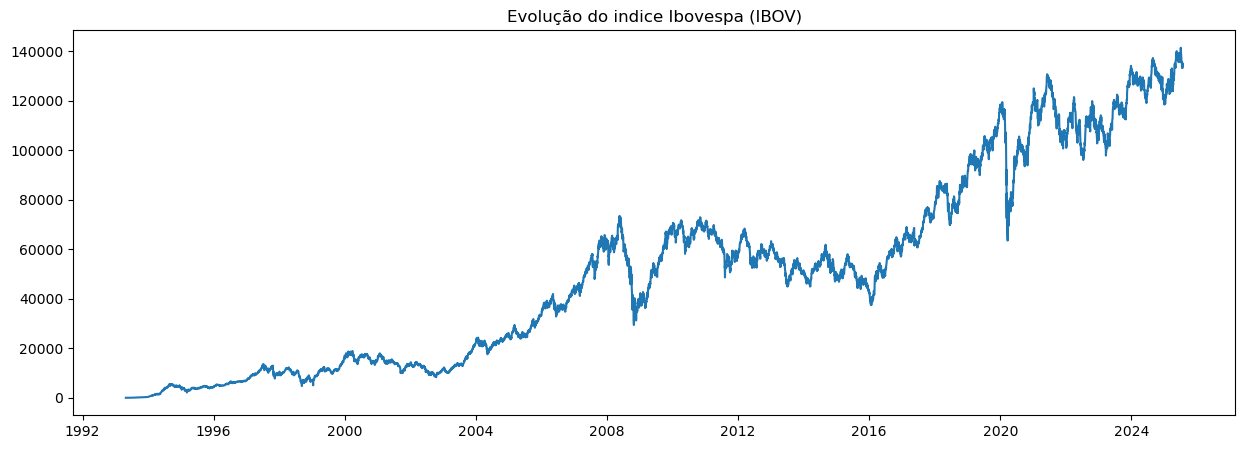

In [11]:
# Plotando um grafico de linha 

plt.figure(figsize=(15,5))
plt.plot(dados_ultimo.index,dados_ultimo)
plt.title("Evolução do indice Ibovespa (IBOV)")
plt.show()

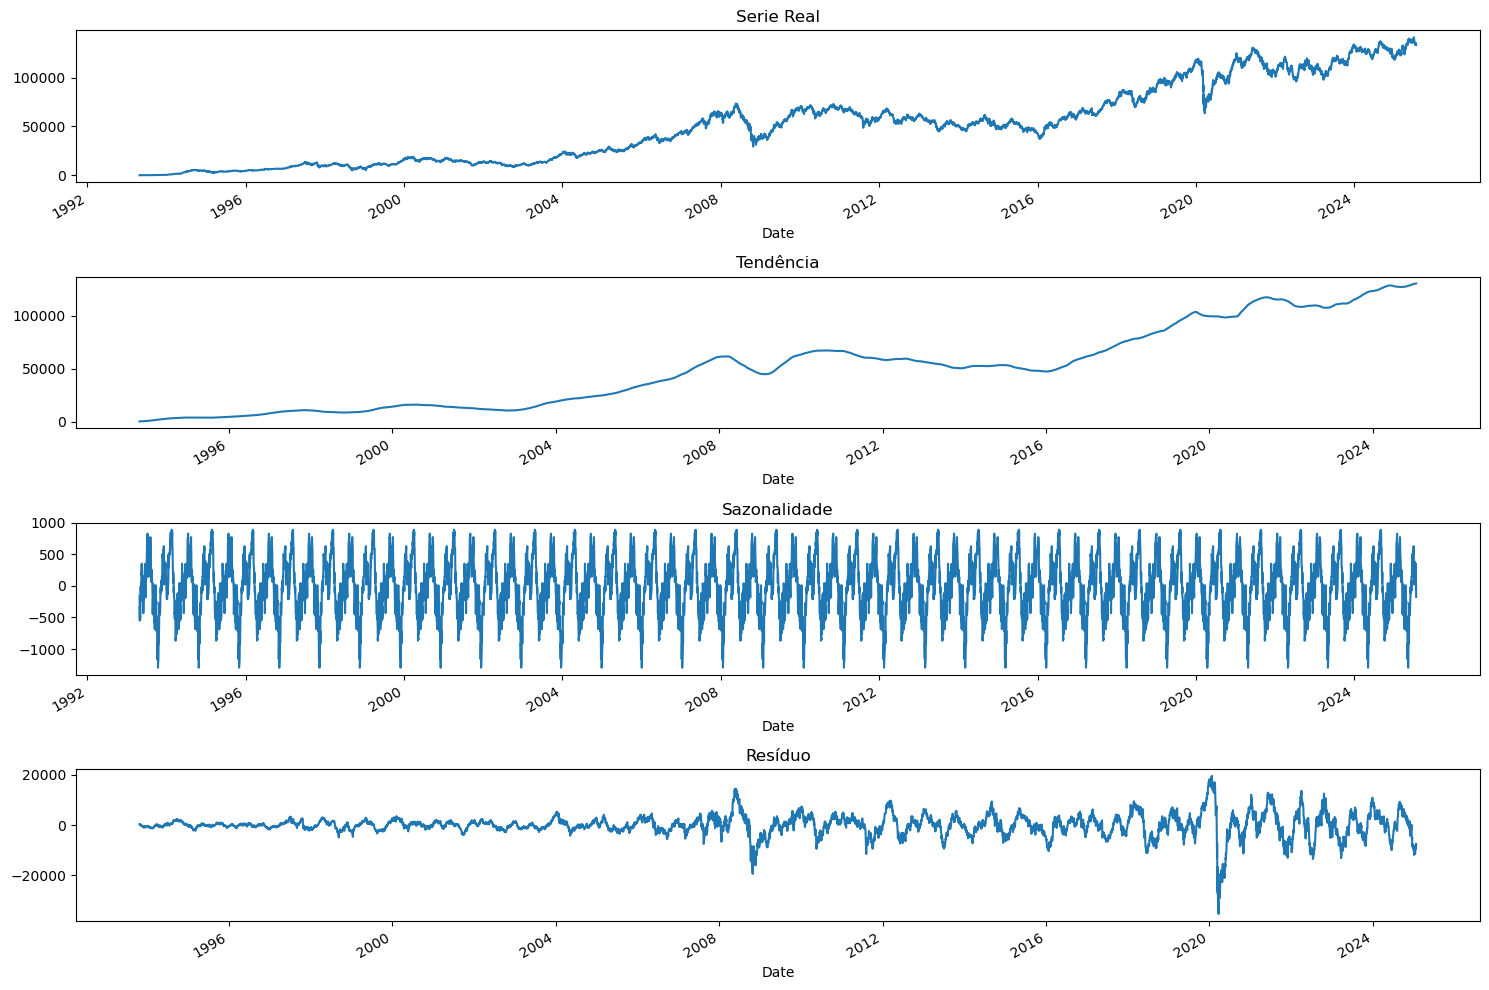

In [12]:
# Realizar a decomposição da seria temporal -->  tendência (trend), sazonalidade (seasonal) e resíduo (resid) e gerar o graficos 

periodo = 252 # Média de dias uteis

resultados = seasonal_decompose(dados_ultimo, period=periodo)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
ax1.set_title("Serie Real")

resultados.trend.plot(ax=ax2)
ax2.set_title("Tendência")

resultados.seasonal.plot(ax=ax3)
ax3.set_title("Sazonalidade")

resultados.resid.plot(ax=ax4)
ax4.set_title("Resíduo")

plt.tight_layout()
plt.show()

In [13]:
# Filtrar dados com volume maior que zero

dados_origem_volume_zero = dados_origem.query("Volume > 0")

print("Dados antes do filtro")
display(dados_origem.head())

print("\nDados após o filtro")
dados_origem_volume_zero.head()

Dados antes do filtro


,Close,High,Low,Open,Volume
Date,,,,,
1993-04-27,24.500000,25.400000,24.500000,24.799999,0
1993-04-28,24.299999,24.600000,23.700001,24.500000,0
1993-04-29,23.700001,24.799999,23.700001,24.299999,0
1993-04-30,24.100000,24.200001,23.700001,23.700001,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0



Dados após o filtro


,Close,High,Low,Open,Volume
Date,,,,,
2002-07-02,10846.0,10908.0,10711.0,10891.0,98006400
2002-07-03,10636.0,10868.0,10520.0,10854.0,98006400
2002-07-04,10655.0,10721.0,10594.0,10661.0,98006400
2006-08-30,36313.0,36520.0,36125.0,36303.0,144235600
2006-09-01,37329.0,37329.0,36232.0,36232.0,98953400


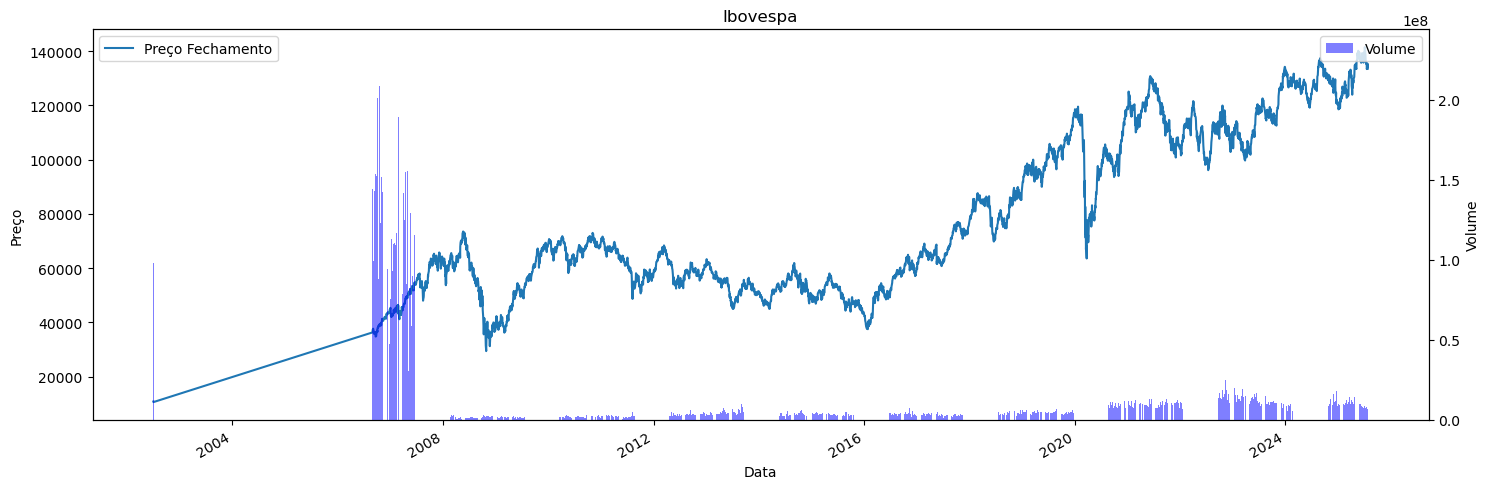

In [14]:
# Plotar o grafico Preco vs Volume 

ax = dados_origem_volume_zero.plot(y='Close', kind='line', label='Preço Fechamento')
ax.set_title('Ibovespa')
ax.set_xlabel('Data')
ax.set_ylabel('Preço')
fig = ax.get_figure()
fig.set_figwidth(15)
fig.set_figheight(5)

ax2 = ax.twinx()
ax2.bar(dados_origem_volume_zero.index, dados_origem_volume_zero['Volume'], alpha=0.5, color='blue', label='Volume')
ax2.set_ylabel('Volume')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

##### Feature Engineering e Target

In [15]:
# Criar um novo data frame com os dados originais

dados = dados_origem.copy()

In [16]:
# Ordernando os dados 

dados = dados.sort_index()

In [17]:
# Criar uma coluna Delta do valor Close (Fechamento)

dados["Delta"] = dados["Close"].diff().shift(1)
dados.tail()

,Close,High,Low,Open,Volume,Delta
Date,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0


In [18]:
# Criar uma coluna binaria com o Target --> Subiu ou desceu o indice 

# Desconsiderar variação menor 0.5% --> Ruidoss
limite = 0.005  

# Criar coluna target com validação do limite
delta = dados['Close'].diff()
dados['Target'] = np.where(delta > limite, 1, np.where(delta < -limite, 0, np.nan))

dados.tail()

,Close,High,Low,Open,Volume,Delta,Target
Date,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0


In [19]:
# Criar uma coluna com variação percentual do valor do fechamento

dados["Return"] = dados["Close"].pct_change().shift(1)
dados.tail()

,Close,High,Low,Open,Volume,Delta,Target,Return
Date,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524


In [20]:
# Criar os lags --> Features Defasadas ou Lagged Features

n_lags = 10

dataset = criar_n_lags(dados, n_lags, "Target")
dados.tail()

,Close,High,Low,Open,Volume,Delta,Target,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10
Date,,,,,,,,,,,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [21]:
# Empurrar(shift) os dados High e Low + Criar coluna Volatilidade

dados["HighShift"] = dados["High"].shift(1)
dados["LowShift"] = dados["Low"].shift(1)

dados["Volatilidade"] = dados["HighShift"] - dados["LowShift"]
dados["Volatilidade_relativa"] = dados["Volatilidade"] / dados["LowShift"]

dados.tail()


,Close,High,Low,Open,Volume,Delta,Target,Return,Target_lag1,Target_lag2,...,Target_lag5,Target_lag6,Target_lag7,Target_lag8,Target_lag9,Target_lag10,HighShift,LowShift,Volatilidade,Volatilidade_relativa
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,135563.0,133296.0,2267.0,0.017007
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,134865.0,133367.0,1498.0,0.011232
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,135300.0,133986.0,1314.0,0.009807
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,135782.0,133676.0,2106.0,0.015755
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,135363.0,133648.0,1715.0,0.012832


In [22]:
dias_medias = [5, 22, 66, 132, 252] 

for dias in dias_medias:
    dados[f"MA_{dias}"] = dados["Close"].rolling(window=dias).mean().shift(1)

dados.tail()

,Close,High,Low,Open,Volume,Delta,Target,Return,Target_lag1,Target_lag2,...,Target_lag10,HighShift,LowShift,Volatilidade,Volatilidade_relativa,MA_5,MA_22,MA_66,MA_132,MA_252
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-21,134167.0,134865.0,133367.0,133382.0,6726700,-2183.0,1.0,-0.016103,0.0,1.0,...,0.0,135563.0,133296.0,2267.0,0.017007,135001.4,137425.818182,136497.833333,131298.583333,130463.000000
2025-07-22,134036.0,135300.0,133986.0,134180.0,7052100,785.0,0.0,0.005885,1.0,0.0,...,0.0,134865.0,133367.0,1498.0,0.011232,134775.0,137219.000000,136569.242424,131408.750000,130483.067460
2025-07-23,135368.0,135782.0,133676.0,134036.0,6527600,-131.0,1.0,-0.000976,0.0,1.0,...,0.0,135300.0,133986.0,1314.0,0.009807,134532.2,137079.000000,136641.833333,131516.742424,130501.265873
2025-07-24,133808.0,135363.0,133648.0,135357.0,5976800,1332.0,0.0,0.009938,1.0,0.0,...,0.0,135782.0,133676.0,2106.0,0.015755,134503.6,137025.227273,136748.666667,131641.833333,130531.884921
2025-07-25,133524.0,134204.0,133285.0,133820.0,5560900,-1560.0,0.0,-0.011524,0.0,1.0,...,0.0,135363.0,133648.0,1715.0,0.012832,134152.2,136872.636364,136811.666667,131753.962121,130556.456349


In [23]:
# Ajustar o Data Frame removendo colunas não necessarias e linhas com valores nulos 

colunas_excluir = ["Close", "High", "Low", "Volume"]
dados = dados.drop(columns=colunas_excluir)
dados = dados.dropna()

dados.index.name = "data"
dados = dados.rename(columns={"HighShift":"High", "LowShift":"Low"})

dados.tail()

,Open,Delta,Target,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,...,Target_lag10,High,Low,Volatilidade,Volatilidade_relativa,MA_5,MA_22,MA_66,MA_132,MA_252
data,,,,,,,,,,,,,,,,,,,,,
2025-07-21,133382.0,-2183.0,1.0,-0.016103,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,135563.0,133296.0,2267.0,0.017007,135001.4,137425.818182,136497.833333,131298.583333,130463.000000
2025-07-22,134180.0,785.0,0.0,0.005885,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,134865.0,133367.0,1498.0,0.011232,134775.0,137219.000000,136569.242424,131408.750000,130483.067460
2025-07-23,134036.0,-131.0,1.0,-0.000976,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,135300.0,133986.0,1314.0,0.009807,134532.2,137079.000000,136641.833333,131516.742424,130501.265873
2025-07-24,135357.0,1332.0,0.0,0.009938,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,135782.0,133676.0,2106.0,0.015755,134503.6,137025.227273,136748.666667,131641.833333,130531.884921
2025-07-25,133820.0,-1560.0,0.0,-0.011524,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,135363.0,133648.0,1715.0,0.012832,134152.2,136872.636364,136811.666667,131753.962121,130556.456349


##### Separa a base entre treino e test

In [24]:
# Gerar datas para filtrar treino e teste 

# Definir o ano e mês do intervalo + anos 
ano = 2025
mes = 6
anos = 10

# Gerar as variaveis 
data_inicio_teste = pd.to_datetime(date(ano, mes, 1))
ultimo_dia = calendar.monthrange(ano, mes)[1]
data_fim_teste = pd.to_datetime(date(ano, mes, ultimo_dia))

ano_atual = date.today().year
ano_inicio_treino = ano_atual - anos
data_inicio_treino = pd.to_datetime(date(ano_inicio_treino,1,1))

In [25]:
# Separar os dados para treino e teste 

preditores = list(dados.columns)
preditores.remove("Target")

x = dados[preditores]
y = dados["Target"]

print("Features (x):")
display(x.tail())

print("\nAlvo (y):")
display(y.tail())

Features (x):


,Open,Delta,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,...,Target_lag10,High,Low,Volatilidade,Volatilidade_relativa,MA_5,MA_22,MA_66,MA_132,MA_252
data,,,,,,,,,,,,,,,,,,,,,
2025-07-21,133382.0,-2183.0,-0.016103,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,135563.0,133296.0,2267.0,0.017007,135001.4,137425.818182,136497.833333,131298.583333,130463.000000
2025-07-22,134180.0,785.0,0.005885,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,134865.0,133367.0,1498.0,0.011232,134775.0,137219.000000,136569.242424,131408.750000,130483.067460
2025-07-23,134036.0,-131.0,-0.000976,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,135300.0,133986.0,1314.0,0.009807,134532.2,137079.000000,136641.833333,131516.742424,130501.265873
2025-07-24,135357.0,1332.0,0.009938,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,135782.0,133676.0,2106.0,0.015755,134503.6,137025.227273,136748.666667,131641.833333,130531.884921
2025-07-25,133820.0,-1560.0,-0.011524,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,135363.0,133648.0,1715.0,0.012832,134152.2,136872.636364,136811.666667,131753.962121,130556.456349



Alvo (y):


data
2025-07-21    1.0
2025-07-22    0.0
2025-07-23    1.0
2025-07-24    0.0
2025-07-25    0.0
Name: Target, dtype: float64

In [26]:
# Separar a base em treino e teste

x_train = x[(x.index >= data_inicio_treino) & (x.index < data_inicio_teste)]
y_train = y[(y.index >= data_inicio_treino) & (y.index < data_inicio_teste)]

x_test = x[(x.index >= data_inicio_teste) & (x.index <= data_fim_teste)]
y_test = y[(y.index >= data_inicio_teste) & (y.index <= data_fim_teste)]

##### Criação dos modelos de Machine Learning

In [27]:
# Normalizar os dados

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
# Treinar o modelo e gerar a previsao - Regressao Logistica

usar_grid = "Não"

if usar_grid == "Sim":

    pipe_lr = Pipeline(
        [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear'))]
    )

    param_grid_lr = {
        'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularização
        'clf__penalty': ['l1', 'l2'],  # tipo de penalização
        'clf__solver': ['liblinear'],  # necessário para suportar l1
    }

    modelo_rl = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
    modelo_rl.fit(x_train, y_train)
    modelo_rl = modelo_rl.predict(x_test)

else: 
    modelo_rl = LogisticRegression(random_state=42)
    modelo_rl.fit(x_train_scaled,y_train)
    previsao_rl = modelo_rl.predict(x_test_scaled)

In [30]:
# Treinar o modelo e gerar a previsao - Random Forest 

modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(x_train_scaled, y_train)
previsao_rf = modelo_rf.predict(x_test_scaled)

In [31]:
# Treinar o modelo e gerar a previsao - XGBoost

usar_grid = "Não"

if usar_grid == "Sim":

    pipe_xgb = Pipeline(
        [
            ('scaler', StandardScaler()),
            ('clf', XGBClassifier()),
        ]
    )

    param_grid_xgb = {
        'clf__n_estimators': [50, 100, 200],  # número de árvores
        'clf__max_depth': [3, 5, 7],  # profundidade da árvore
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.3],  # taxa de aprendizado
        'clf__subsample': [0.6, 0.8, 1.0],  # fração das amostras usadas em cada árvore
        'clf__colsample_bytree': [0.6, 0.8, 1.0],  # fração de colunas usadas por árvore
        'clf__gamma': [0, 0.1, 0.5, 1.0],  # regularização mínima para divisão
        'clf__reg_alpha': [0, 0.1, 1],  # L1 regularization
        'clf__reg_lambda': [0.1, 1, 10],  # L2 regularization
    }

    modelo_xgb = RandomizedSearchCV(pipe_xgb, param_grid_xgb, cv=tscv)
    modelo_xgb.fit(x_train, y_train)
    previsao_xgb = modelo_xgb.predict(x_test)

else:
    modelo_xgb = XGBClassifier(random_state=42)
    modelo_xgb.fit(x_train_scaled, y_train)
    previsao_xgb = modelo_xgb.predict(x_test_scaled)

In [32]:
# Gerar tabela com o score

# # Criar um dicionario com os resultados centralizado que guarda o nome, o objeto do modelo e suas previsões
modelos_avaliados = {
    "Regressão Logística": {"modelo": modelo_rl, "previsoes": previsao_rl},
    "Random Forest":       {"modelo": modelo_rf, "previsoes": previsao_rf},
    "XGBoost":             {"modelo": modelo_xgb, "previsoes": previsao_xgb}
}

# Criar um data frame com os resultados
performance = pd.DataFrame(
    columns=["Modelo", "Acurácia", "Precisão", "Recall", "F1-Score"]
)

for nome, dados in modelos_avaliados.items():
    report = classification_report(y_test, dados["previsoes"], output_dict=True, zero_division=0)
    
    performance.loc[performance.shape[0]] = {
        "Modelo": nome,
        "Acurácia": report["accuracy"],
        "Precisão": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
    }

performance.set_index("Modelo", inplace=True)
performance_formatada = performance.sort_values(by="Acurácia", ascending=False)
performance_formatada = performance_formatada.map(lambda x: f"{(100 * x):.2f} %")

display(performance_formatada)

,Acurácia,Precisão,Recall,F1-Score
Modelo,,,,
Random Forest,60.00 %,36.00 %,60.00 %,45.00 %
Regressão Logística,55.00 %,48.63 %,55.00 %,48.65 %
XGBoost,55.00 %,54.07 %,55.00 %,54.40 %


##### Analisando o resultado dos modelos de Machine Learning através da Matriz de Confusão e Curva ROC

In [33]:
# Gerar a matriz de confusão e Curva ROC 

# Selecionar como default o modelo com a melhor acurácia
modelo_default = performance.sort_values(by="Acurácia", ascending=False).index[0]

# Criar o menu suspenso 
dropdown = widgets.Dropdown(
    options=list(modelos_avaliados.keys()),
    value=modelo_default,
    description='Modelo: ',
    disabled=False
)

widgets.interactive(
    lambda nome_modelo: analisar_modelo_selecionado(nome_modelo, modelos_avaliados, y_test, x_test_scaled),
    nome_modelo=dropdown
)

interactive(children=(Dropdown(description='Modelo: ', index=1, options=('Regressão Logística', 'Random Forest…